# Final Project: Classification and Captioning Aircraft Damage Using Pretrained Models


# Objectives for this Notebook

Automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. 
Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

After you complete the project, you will be able to:

- Use the VGG16 model for image classification.
- Prepare and preprocess image data for a machine learning task.
- Evaluate the model’s performance using appropriate metrics.
- Visualize model predictions on test data.
- Use a custom Keras layer. 

You will be using the [Aircraft dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar).
The dataset is taken from the here (Original Source): [Roboflow Aircraft Dataset](https://universe.roboflow.com/youssef-donia-fhktl/aircraft-damage-detection-1j9qk) Provided by a Roboflow user, License: CC BY 4.


<h2>Table of Contents</h2>
 
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <p><font size="5">Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'</p>
<font size="3">
        1. <a href="#1.1-Dataset-Preparation">1.1 Dataset Preparation</a><br>
        2. <a href="#1.2-Data-Preprocessing">1.2 Data Preprocessing</a><br>
        3. <a href="#1.3-Model-Definition">1.3 Model Definition</a><br>
        4. <a href="#1.4-Model-Training">1.4 Model Training</a><br>
        5. <a href="#1.5-Visualizing-Training-Results">1.5 Visualizing Training Results</a><br>
        6. <a href="#1.6-Model-Evaluation">1.6 Model Evaluation</a><br>
        7. <a href="#1.7-Visualizing-Predictions">1.7 Visualizing Predictions</a><br>
    <br>
<p><font size="5">Part 2: Image Captioning and Summarization using BLIP Pretrained Model</p>
<font size="3">
        1. <a href="#2.1-Loading-BLIP-Model">2.1 Loading BLIP Model</a><br>
        2. <a href="#2.2-Generating-Captions-and-Summaries">2.2 Generating Captions and Summaries</a><br>
        <br>
    


# 1.1 Dataset-Preparation


### Task List
To achieve the above objectives, you will complete the following tasks:

- Task 1: Create a `valid_generator` using the `valid_datagen` object
- Task 2: Create a `test_generator` using the `test_datagen` object
- Task 3: Load the VGG16 model
- Task 4: Compile the model
- Task 5: Train the model
- Task 6: Plot accuracy curves for training and validation sets 
- Task 7: Visualizing the results 
- Task 8: Implement a Helper Function to Use the Custom Keras Layer
- Task 9: Generate a caption for an image using the using BLIP pretrained model
- Task 10: Generate a summary of an image using BLIP pretrained model

## Setup


In [1]:
import warnings
warnings.filterwarnings('ignore')

### Installing Required Libraries


In [2]:
!pip install pandas==2.2.3
!pip install tensorflow_cpu==2.17.1
!pip install pillow==11.1.0
!pip install matplotlib==3.9.2
!pip install transformers==4.38.2
!pip install torch==2.2.0+cpu torchvision==0.17.0+cpu torchaudio==2.2.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


#### Suppress the tensorflow warning messages


In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Importing Required Libraries


In [4]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [5]:
# Set seed for reproducibility
# This seed guarantees the same random behavior across runs
# Set controlled randomness can lead to non-reproducible results.
seed_value = 42
random.seed(seed_value) 
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#### Pretrained Model
- **ResNet, VGG (Image Classification):** commonly used for image classification tasks.
- **BLIP (Image Captioning and Summarization):** can generate captions and summaries for images.

## <a id='toc1_'> </a> [Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'](#toc1_) 

### <a id='toc1_1_'></a> [1.1 Dataset Preparation](#toc1_) 
The goal is to train an algorithm on these images and to predict the labels for images in your test set.

In [6]:
#Set the batch size,epochs
batch_size = 32 #number of training examples fed to the model at once
n_epochs = 5
img_rows, img_cols = 224, 224 # Most pretrained models expect 224×224 pixels.
input_shape = (img_rows, img_cols, 3) # 3 channels → RGB color images.

In [7]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.
Removed the existing folder: aircraft_damage_dataset_v1
Extracted aircraft_damage_dataset_v1.tar successfully.


The folder structure looks as follows:

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```



In [8]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## 1.2 Data Preprocessing

Create data generators for training, validation, and testing datasets. Data generators are objects/functions that load and preprocess data in batches on the fly instead of loading the entire dataset into memory at once.

The ImageDataGenerator class is part of Keras for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset  to improve model generalization. 

In [9]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255) # rescale to Normalize pixel values
valid_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

## **Step 1: Create a `train_generator` using the `train_datagen` object**
we use flow_from_directory() method to read images directly from the directory and generate batches of data that will be fed into the model for training.

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


Plot first 2 images in the batch

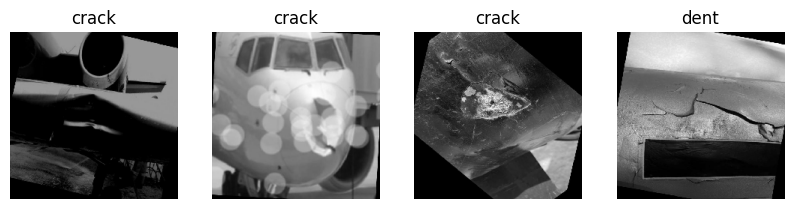

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot first 4 images in the batch
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])               # Images are already normalized (0-1)
    label = 'dent' if labels[i]==0 else 'crack'
    plt.title(label)
    plt.axis('off')
plt.show()

## **Step 2: Create a `valid_generator` using the `valid_datagen` object**

In [12]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


## **Step 3: Create a `test_generator` using the `test_datagen` object**

In [13]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


## 1.3 Model Definition

Now, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.
That is why, we  exclude the fully connected layers (the “top”) used for ImageNet classification (later, we add our dense layer).

## **Step 1: Load the pre-trained model VGG16**

In [14]:
base_model = VGG16(
    weights='imagenet', # Load pretrained weights trained on the ImageNet dataset
    include_top=False, # exclude the fully connected layers (the “top”) used for ImageNet classification
    input_shape=(img_rows, img_cols, 3)
)


Now, we modify the VGG16 model for our specific classification task.
1. extract the output from the last layer of the pre-trained VGG16 model, 
2. create a new model with this modified output. 
3. freeze the base VGG16 model layers so that their weights will not be updated during training.


In [15]:
output = base_model.layers[-1].output # extract the last layer output (convolutional features)
output = keras.layers.Flatten()(output) # # flatten feature maps to a 1D vector
base_model = Model(base_model.input, output) # create a new model with this modified output

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. 
* This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting.

In [16]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu')) #dense layer with 512 units
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu')) #dense layer with 512 units
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # sigmoid activation to output the probability for binary classification ("dent" vs "crack").

## **Step 2: Compile the model**

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


## 1.4 Model Training


## **Step 1: Train the model**


In [18]:
history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5900 - loss: 0.6939 - val_accuracy: 0.6458 - val_loss: 0.6137
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7200 - loss: 0.5309 - val_accuracy: 0.6875 - val_loss: 0.5884
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7767 - loss: 0.4782 - val_accuracy: 0.7396 - val_loss: 0.5231
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8267 - loss: 0.3974 - val_accuracy: 0.6771 - val_loss: 0.5412
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8800 - loss: 0.3147 - val_accuracy: 0.6875 - val_loss: 0.4895


In [19]:
# Access the training history
train_history = model.history.history  # After training

## 1.5 Visualizing Training Results

- After training the model, we visualize the training and validation accuracy and loss to understand the model's learning process.


### **Step 1: Plot loss curves for training and validation sets**


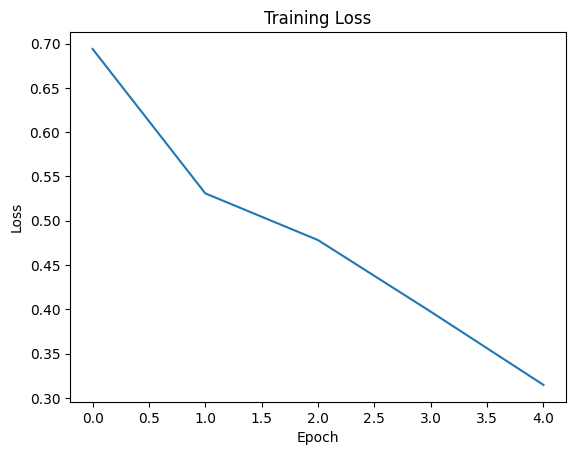

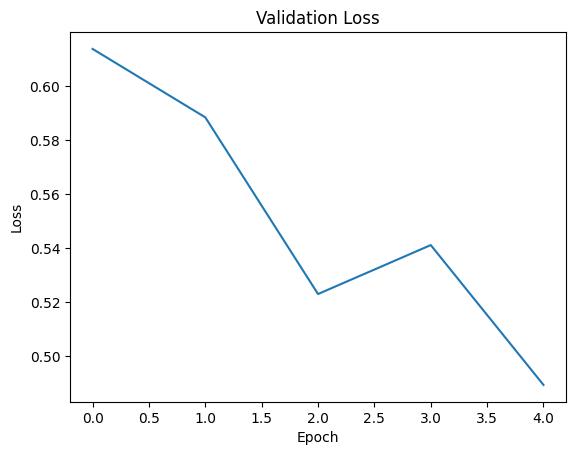

In [20]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

## **Step 2: Plot accuracy curves for training and validation sets**

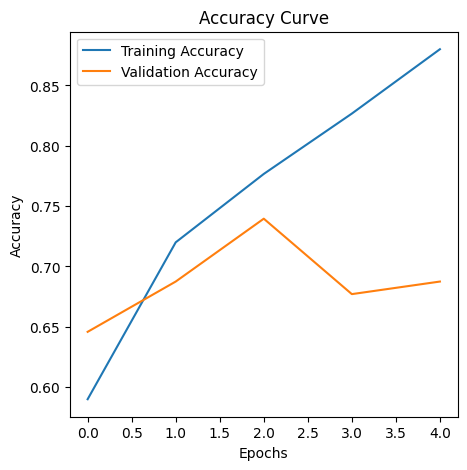

In [21]:
train_history = history.history

plt.figure(figsize=(5, 5))
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 1.6 Model Evaluation


In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6875 - loss: 0.6741
Test Loss: 0.6741
Test Accuracy: 0.6875


 ## 1.7 Visualizing Predictions

Display test images alongside their true and predicted labels.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




## **Step 1: Visualizing the results**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


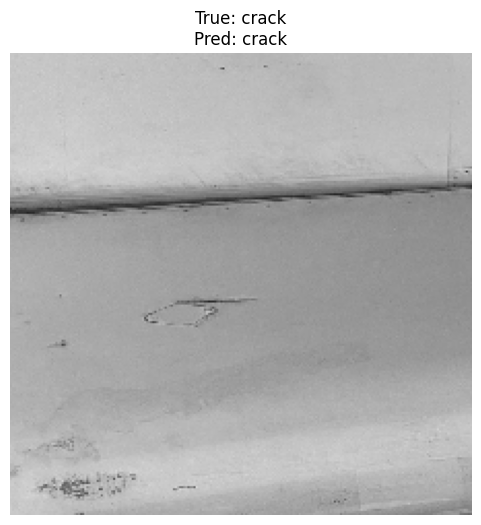

In [24]:

index_to_plot = 1

test_model_on_image(
    test_generator,   # test_data_generator
    model,            # trained model
    index_to_plot=index_to_plot
)


## <a id='toc2_'></a>[Part 2: Image Captioning and Summarization using BLIP Pretrained Model](#toc2_)


BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.


In [25]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

/home/aq/installations/python_envs/ml_env/bin/python
2.2.0+cpu


## 2.1 Loading BLIP Model


#### Load the BLIP Model and Processor from Hugging Face

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.


In [26]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

#### Custom Keras Layer: BlipCaptionSummaryLayer

Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass `tf.keras.layers.Layer` and implement the required methods.

#### **BlipCaptionSummaryLayer Class:**

This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

- **`__init__`**: This constructor method initializes the `BlipCaptionSummaryLayer` class by setting up the BLIP processor and model.
  
- **`call`**: This method defines the operations or transformations applied to the input data as it passes through the layer.

- **`process_image`**: The `process_image` method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.


In [27]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


## **Step 1: Implement a Helper Function to Use the Custom Keras Layer**

In [31]:
# Define a helper function to use the custom Keras layer
def generate_text(image_path, task):
    # Create an instance of the custom Keras layer using the pretrained BLIP processor and model
    blip_layer = BlipCaptionSummaryLayer(processor, model)

    # Call the layer with the provided inputs
    return blip_layer(image_path, task)



## 2.2 Generating Captions and Summaries


Now we use the `generate_text` function to generate a caption and a summary for an image.
It processes the image and prints the corresponding text output in a human-readable format.
The function makes it easy to switch between generating captions and summaries based on the task type you provide.</br>
</br>

**Note:** Generated captions/summary may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.



In [32]:

# Path to an example image 
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


## **Step 1: Generate a caption for an image using the using BLIP pretrained model**

- Use the image_path variable given below to load the image. Run the cell to before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task

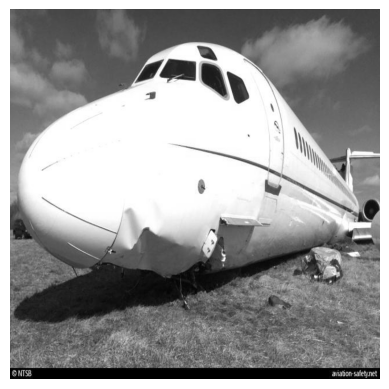

In [33]:
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [39]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [40]:
# Write your code here
# The given image path (already provided in the notebook)
#image_path = ""   # <-- Replace only if instructed

# Convert image path and task into tensors
import tensorflow as tf

image_tensor = tf.constant(image_path)
task_tensor = tf.constant("caption")

# Generate caption using your helper function
caption_output = generate_text(image_tensor, task_tensor)

# Display the caption
caption_output


<tf.Tensor: shape=(), dtype=string, numpy=b'this is a picture of a plane that was sitting on the ground in a field'>

## **Step 2: Generate a summary of an image using BLIP pretrained model**

- Use the image_path variable given below to load the image. Run the cell before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task

**Note:** Generated summary may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.


In [41]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [42]:
# Write your code here
# The given image path (already provided in the notebook)
#image_path = "/content/sample_image.jpg"   # <-- Keep as provided unless told otherwise

# Convert image path and task into tensors
import tensorflow as tf

image_tensor = tf.constant(image_path)
task_tensor = tf.constant("summary")   # <-- Task changed to 'summary'

# Generate summary using the helper function
summary_output = generate_text(image_tensor, task_tensor)

# Display the summary
summary_output


<tf.Tensor: shape=(), dtype=string, numpy=b'this is a detailed photo showing the damage to the fuselage of the aircraft'>